Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [37]:
# Install and Import required libraries.
!pip install Augmentor
!pip install keras-layer-normalization

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from glob import glob

import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization

In [38]:
## Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
# Setting root path for the notebook and data set
root_path = '/content/gdrive/MyDrive/Colab Notebooks/'  #change dir to your project folder
os.chdir(root_path)

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [40]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("../Colab Notebooks/Train/")
data_dir_test = pathlib.Path('../Colab Notebooks/Test/')
print("Train Path : ",data_dir_train)
print("Test Path : ",data_dir_test)

Train Path :  ../Colab Notebooks/Train
Test Path :  ../Colab Notebooks/Test


In [41]:
# Get the number of images from Train and Test Folders
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Images : ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Images : ", image_count_test)

Train Images :  2239
Test Images :  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [42]:
# Before Load keras preprocessing Lets Define the parameters
batch_size = 32
img_height = 180
img_width = 180

In [43]:
# Lets select 80% of the Images to Train
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [44]:
# Lets select 20% of the images for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


Now we have 80% of the images for training, and 20% for validation.

In [45]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Observation :
There are 9 Image Classes.

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

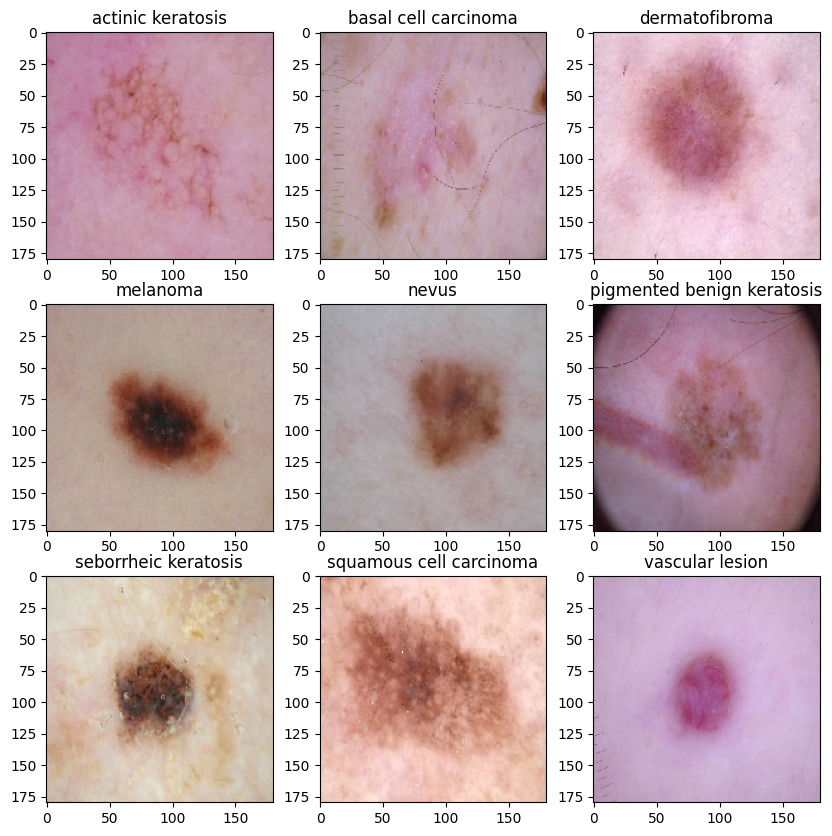

In [46]:
# Using matplotlib.pyplot to visualize the Training and Validation Data.
plt.figure(figsize=(10, 10))


#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)

In [47]:
# Method to Visualize Stats
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

In [48]:
# Visualize class wise Train Stats
train_df = class_distribution_count(data_dir_train)
train_df

,Class,No. of Image
0,vascular lesion,139
1,squamous cell carcinoma,181
2,nevus,357
3,pigmented benign keratosis,462
4,melanoma,438
5,seborrheic keratosis,77
6,actinic keratosis,114
7,basal cell carcinoma,376
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

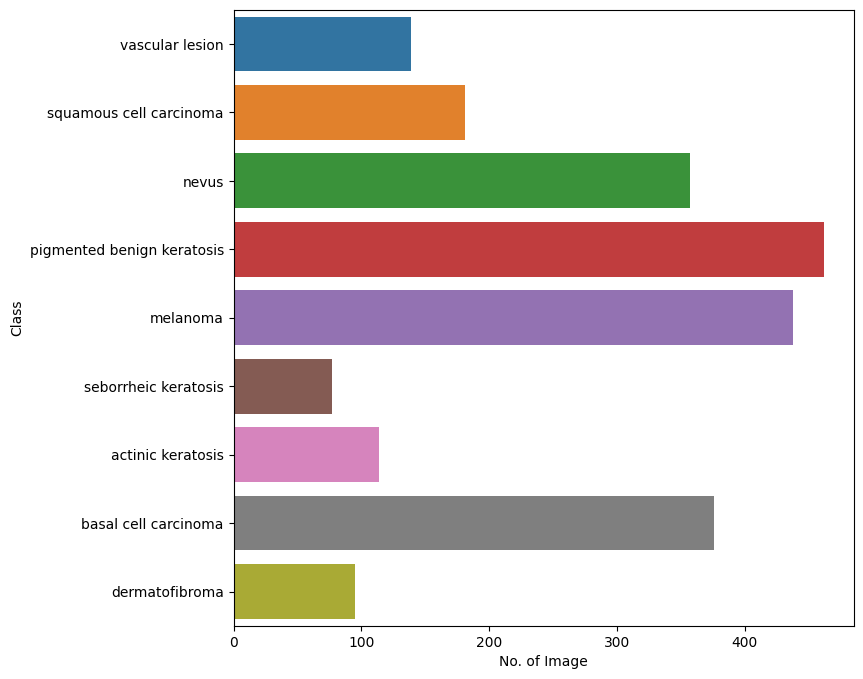

In [49]:
#Visualize the Number of image in each class for Train.
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.barplot(x="No. of Image", y="Class", data=train_df,
            label="Class")

#### Observation :
- There is class imbalance, we will handle this after we create first model.

In [50]:
# Visualize class wise test  Data set
test_df = class_distribution_count(data_dir_test)
test_df

,Class,No. of Image
0,basal cell carcinoma,16
1,seborrheic keratosis,3
2,dermatofibroma,16
3,melanoma,16
4,squamous cell carcinoma,16
5,nevus,16
6,vascular lesion,3
7,pigmented benign keratosis,16
8,actinic keratosis,16


<Axes: xlabel='No. of Image', ylabel='Class'>

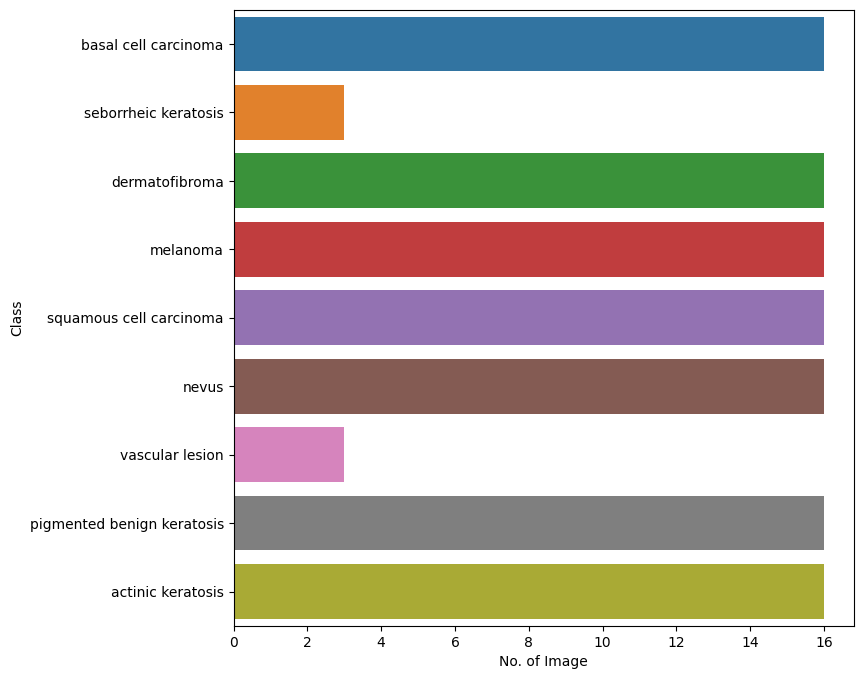

In [51]:
#Visualize the Number of image in each class for Test Data set
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.barplot(x="No. of Image", y="Class", data=test_df,
            label="Class")

In [52]:
# Let check the Batch Size and Shape of the images.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 9)


- The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`.
  - This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB).
- The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

# Model Creation

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [54]:
# Experimental API for building input pipelines
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Model Creaton to accurately detect 9 classes present in the dataset.
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
# Convulation Layr - 1
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
# Convulation Layr - 2
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convulation Layr - 3
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout @ 0.25
model.add(Dropout(0.25))
# Convulation Layr - 4
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout @ 0.25
model.add(Dropout(0.25))
# Convulation Layr - 5
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout @ 0.5
model.add(Dropout(0.5))

# Flatten
model.add(Flatten())
# Dense with Softmax
model.add(Dense(num_classes, activation = "softmax"))

In [ ]:
# summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
### Using 'Adam' Optimizer as it converges faster than SGD
### We can also use 'momentum' with Sgd, but for now we are using 'Adam' as optimizer
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [ ]:
# View the summary of all layers after Compilation
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

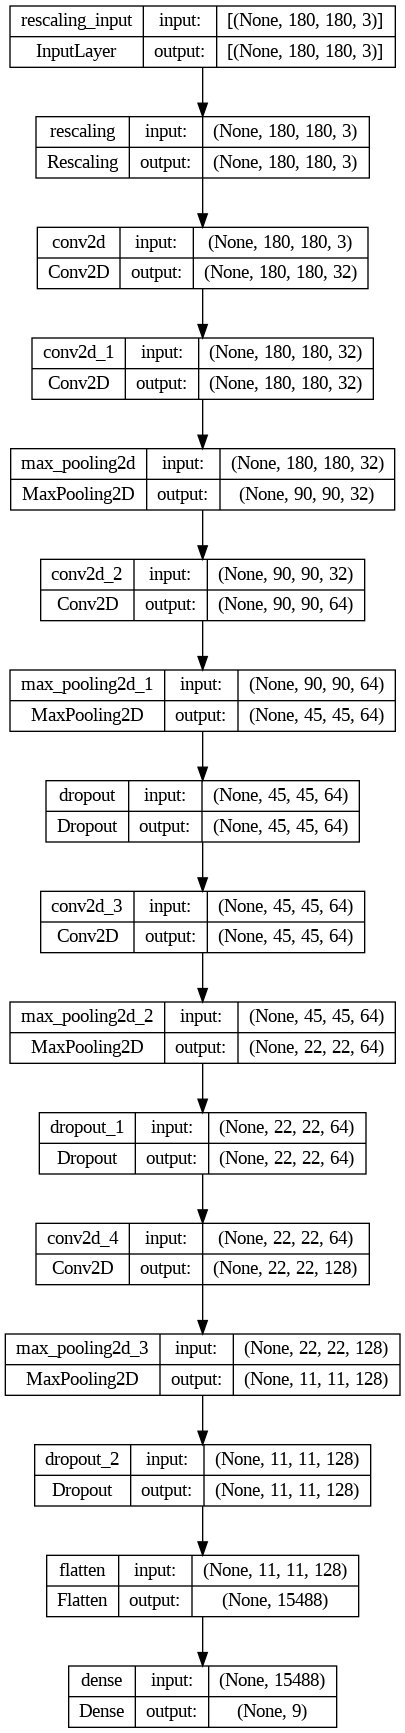

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Observation
- We have input as 9 classes and output is the same.

### Train the model

In [ ]:
# Training the Model with epochs
epochs = 20
# Train the Model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 1085s 14s/step - loss: 2.0470 - accuracy: 0.2121 - val_loss: 1.9959 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 693s 12s/step - loss: 1.9049 - accuracy: 0.3069 - val_loss: 1.6547 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 671s 12s/step - loss: 1.6776 - accuracy: 0.3940 - val_loss: 1.5867 - val_accuracy: 0.4206
Epoch 4/20
56/56 [==============================] - 648s 12s/step - loss: 1.5849 - accuracy: 0.4347 - val_loss: 1.6848 - val_accuracy: 0.4094
Epoch 5/20
56/56 [==============================] - 666s 12s/step - loss: 1.6057 - accuracy: 0.4163 - val_loss: 1.5435 - val_accuracy: 0.4564
Epoch 6/20
56/56 [==============================] - 674s 12s/step - loss: 1.5325 - accuracy: 0.4593 - val_loss: 1.5776 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 672s 12s/step - loss: 1.4723 - accuracy: 0.4860 - val_loss: 1.4423 - val_accuracy: 0.4899
Epoch

#### Visualizing training results




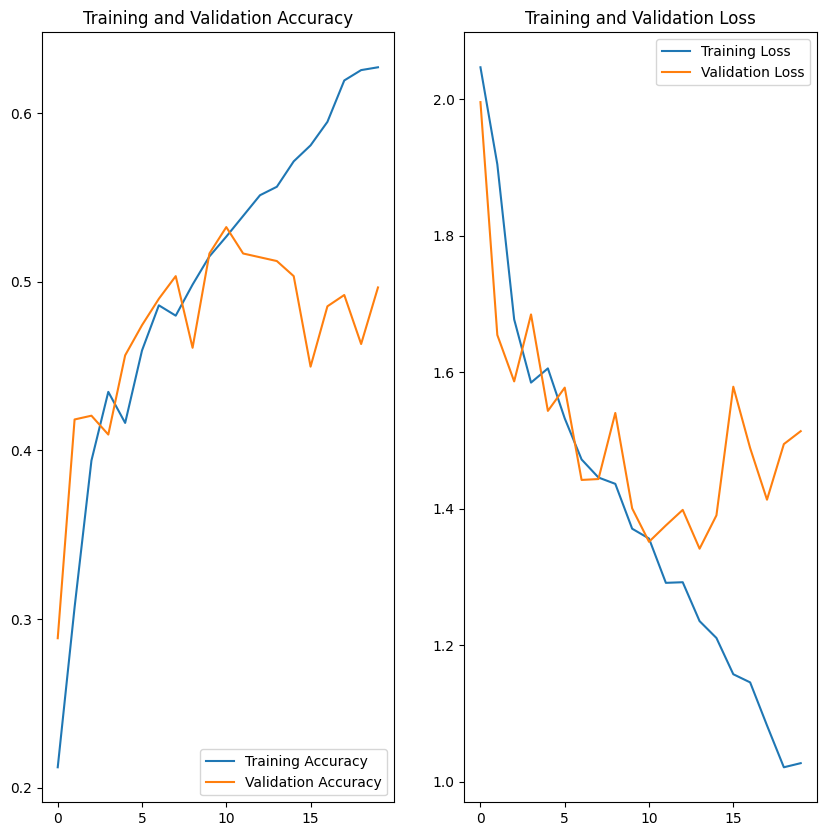

In [ ]:
# Visualize using Plot
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Print the Train and Validation Accuracy & Loss
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Train Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Train Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 40s 3s/step - loss: 1.5138 - accuracy: 0.4966
Train Accuracy:  0.70703125
Validation Accuracy:  0.4966442883014679
Train Loss:  0.8811444044113159
Validation Loss 1.513775110244751


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### Observations:
- Model is overfitting, the gap between Training Accuracy and Validation Accuracy starts increasing from epoch 11 onwards and demonstrates that the model is overfitting.
- Similar trend is noticed in the Loss chart, where the gap between the training and validation loss increases post the epoch 11 pass.
- We have used Drop out in the model definition and included that in the CNN architecture defined for the model, next
  - We can augument the data
  - We can use CallBack for EarlyStop and monitor the Validation Accuracy.


In [55]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

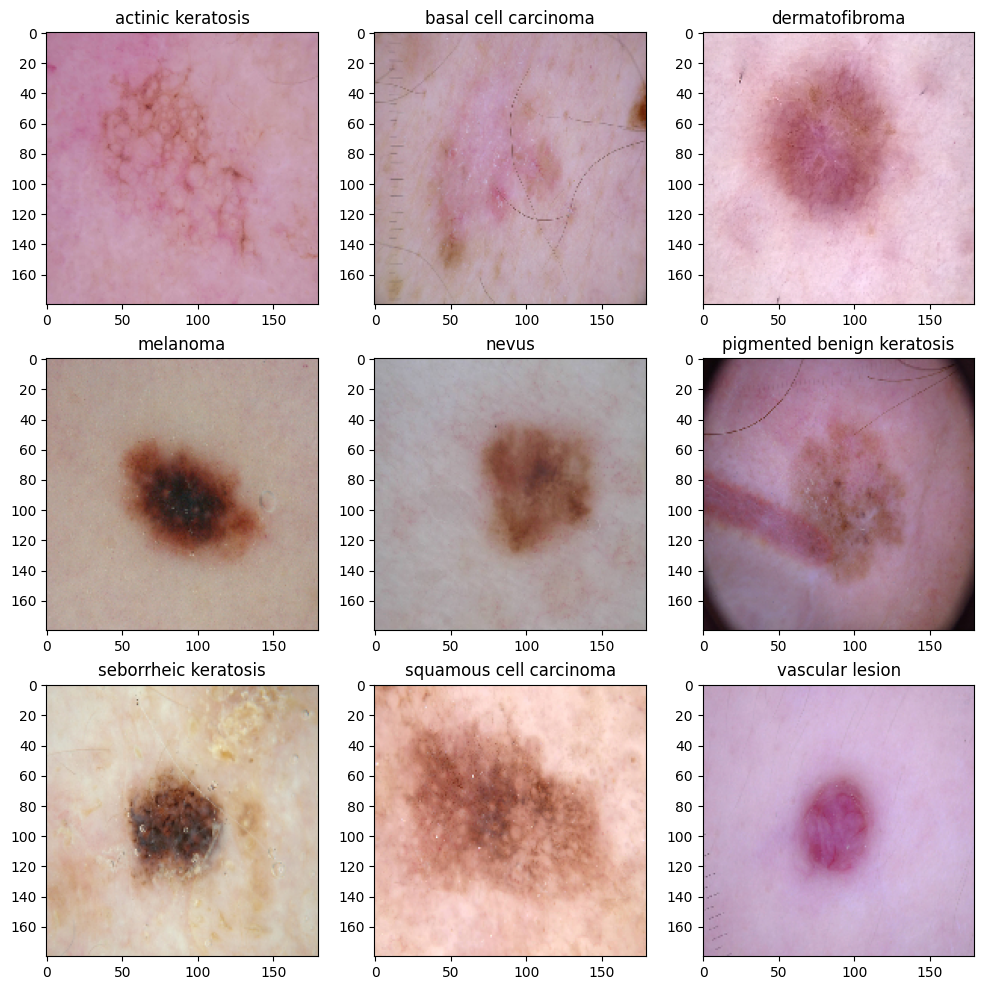

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    #plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
    plt.title(c)

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
# Convulation Layer - 1
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size=(2,2)))
# Convulation Layer - 2
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convulation Layer - 3
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Setting Dropout Layer with 0.25 units to drop
model.add(Dropout(0.25))
# Convulation Layer - 4
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Setting Dropout Layer with 0.5 units to drop
model.add(Dropout(0.5))
# Flatten Layer
model.add(Flatten())
# Dense Layer
model.add(layers.Dense(128,activation='relu'))
# Setting Dropout Layer with 0.25 units to drop
model.add(Dropout(0.25))
# Dense LAyer with Softmax
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [ ]:
## Model Compilation
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
# Model Summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

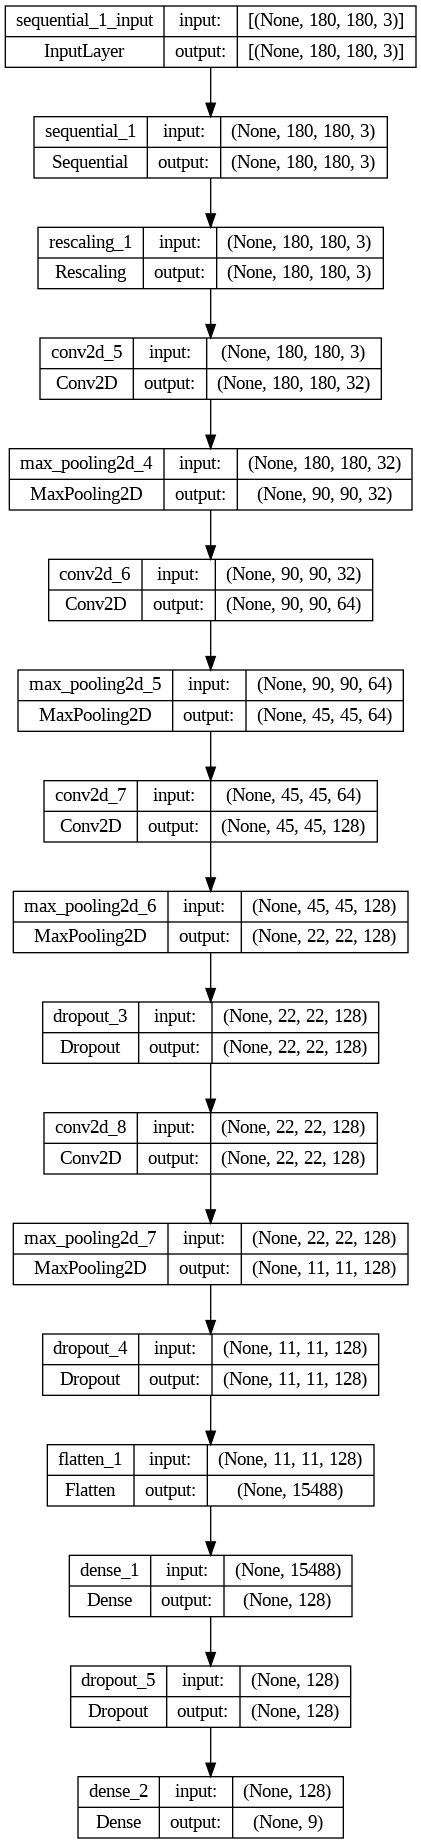

In [ ]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training the model

In [ ]:
## Your code goes here, note: train your model for 30 epochs
# Increase epochs to 30
epochs=30
# Setting CheckPoint
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
# Setting EarlyStop - Focusing on Accuracy
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
# Train the Model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 2.0843 - accuracy: 0.1752
Epoch 1: val_accuracy improved from -inf to 0.20582, saving model to model.h5
56/56 [==============================] - 430s 7s/step - loss: 2.0843 - accuracy: 0.1752 - val_loss: 2.0142 - val_accuracy: 0.2058
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.9872 - accuracy: 0.2254
Epoch 2: val_accuracy improved from 0.20582 to 0.23490, saving model to model.h5
56/56 [==============================] - 389s 7s/step - loss: 1.9872 - accuracy: 0.2254 - val_loss: 1.9883 - val_accuracy: 0.2349
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 1.9133 - accuracy: 0.2768
Epoch 3: val_accuracy improved from 0.23490 to 0.34004, saving model to model.h5
56/56 [==============================] - 389s 7s/step - loss: 1.9133 - accuracy: 0.2768 - val_loss: 1.8217 - val_accuracy: 0.3400
Epoch 4/30
56/56 [==============================] - ETA: 0s - loss: 1.8336 - accuracy: 0

### Visualizing the results

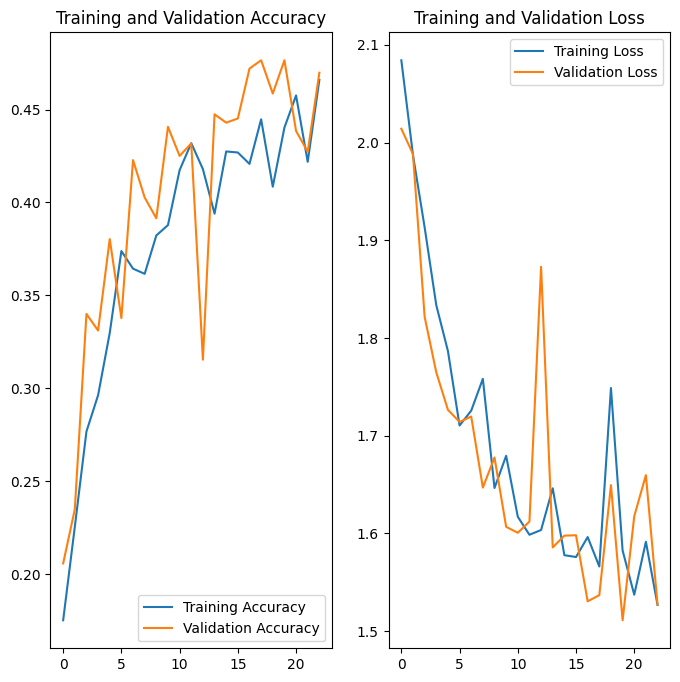

In [ ]:
# Visual results using Plot
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Print the Train and Validation Accuracy & Loss
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Train Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Train Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 25s 2s/step - loss: 1.5273 - accuracy: 0.4698
Train Accuracy:  0.453125
Validation Accuracy:  0.46979865431785583
Train Loss:  1.505170226097107
Validation Loss 1.5272585153579712


#### Observation:
- The Overfitting problem seems to be resolved.
  - The Training and Validation Accuracy & Loss seems to be trending along side.
- However, the Accuracy is not great and needs improvement.
  - Also, with Validation Accuracy a bit higher than Training Accuracy seems like the model is tending to bit underfit.
- We noticed earlier that the data seems to be imbalanced, where certain classes have substantially fewer images than the other classes.
  - Lets look at whether resolving this imbalance helps us in improving the Accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [56]:
## Lets get the number of sample details in a dataframe and analyse whether there is imbalance between / across classes
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_org = dict(zip(path_list, lesion_list))
org_df =pd.DataFrame(list(dataframe_dict_org.items()),columns = ['Path','Label'])
org_df

,Path,Label
0,../Colab Notebooks/Train/actinic keratosis/ISI...,actinic keratosis
1,../Colab Notebooks/Train/actinic keratosis/ISI...,actinic keratosis
2,../Colab Notebooks/Train/actinic keratosis/ISI...,actinic keratosis
3,../Colab Notebooks/Train/actinic keratosis/ISI...,actinic keratosis
4,../Colab Notebooks/Train/actinic keratosis/ISI...,actinic keratosis
...,...,...
2234,../Colab Notebooks/Train/vascular lesion/ISIC_...,vascular lesion
2235,../Colab Notebooks/Train/vascular lesion/ISIC_...,vascular lesion
2236,../Colab Notebooks/Train/vascular lesion/ISIC_...,vascular lesion
2237,../Colab Notebooks/Train/vascular lesion/ISIC_...,vascular lesion


In [57]:
# See the count of images to see if there is imbalance
org_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<BarContainer object of 9 artists>

<Figure size 800x800 with 0 Axes>

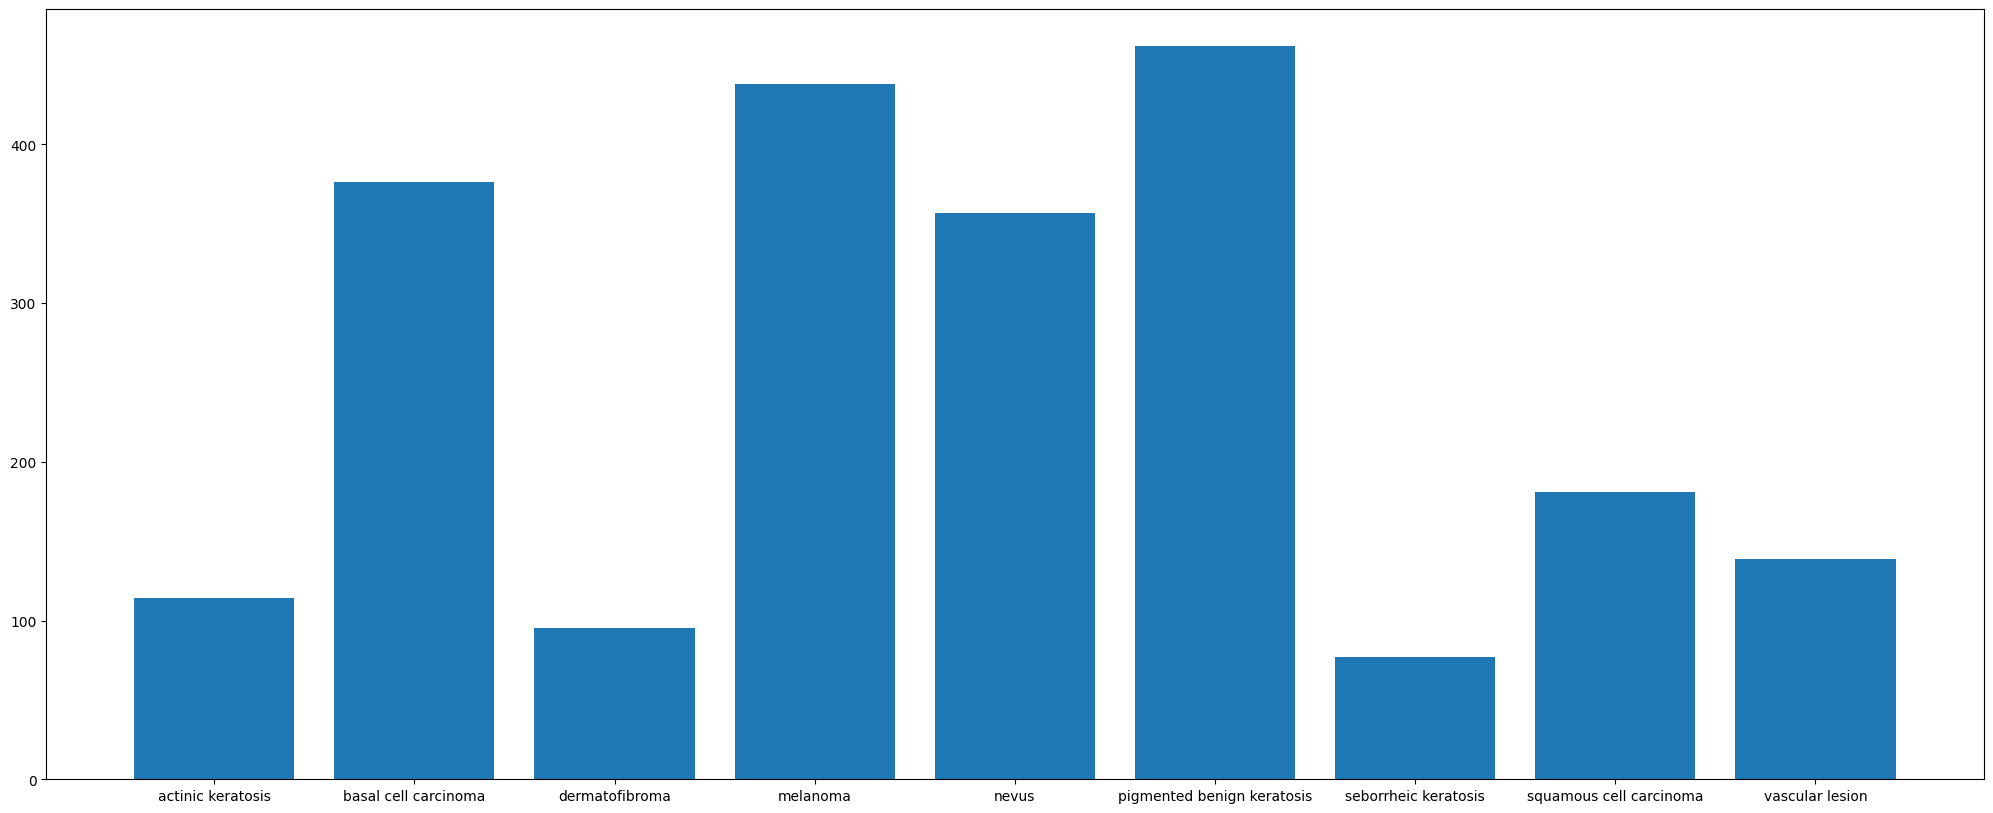

In [58]:
# Lets plot bar chart and check the number of samples across classes
plt.figure(figsize=(8, 8))
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Observation :

#### 1. Which class has the least number of samples?
###### Class "seborrheic keratosis" has less than 100 samples and is the class with least number of samples.

#### 2. Which classes dominate the data in terms proportionate number of samples?
###### Classes "melanoma" and "pigmented benign keratosis" dominate in terms of proprtionate number of samples, with high number of samples when compared to the rest of the Classes.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [59]:
# Using Augmentor to rectify the imbalance
# we have already pip installed the augmentor.
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Train/"
#data_dir_train = pathlib.Path(root_path + '/Train/')
#print(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F02B6B4BD30>: 100%|██████████| 500/500 [00:21<00:00, 23.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F02B70DF250>: 100%|██████████| 500/500 [00:21<00:00, 22.85 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F02B6AFF640>: 100%|██████████| 500/500 [00:22<00:00, 22.01 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F02B6ABBBB0>: 100%|██████████| 500/500 [01:54<00:00,  4.38 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F02B6B057B0>: 100%|██████████| 500/500 [01:42<00:00,  4.89 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F03579F2B60>: 100%|██████████| 500/500 [00:21<00:00, 23.54 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0357997FA0>: 100%|██████████| 500/500 [00:49<00:00, 10.05 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F02B6B78340>: 100%|██████████| 500/500 [00:22<00:00, 22.66 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F02B6B4A1A0>: 100%|██████████| 500/500 [00:21<00:00, 23.09 Samples/s]


- Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.
- Lets take a look at total count of augmented images.

In [60]:
# Count of Sample Images created by Augmentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [61]:
# List the directory where these sample images are created
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['../Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0026393.jpg_db5a5dc7-dac5-4014-ab1a-74e78a364447.jpg',
 '../Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0031217.jpg_dc79577a-542c-4a72-98d2-020011f3fe9f.jpg',
 '../Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0030275.jpg_896de7aa-cbc4-4f4d-bc81-fdf4dbfc5bda.jpg',
 '../Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0031276.jpg_28af739e-bfbf-4b4b-ac1e-284fe580c811.jpg',
 '../Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0033608.jpg_44ca0559-d8e0-484c-9f7f-399d75ab188c.jpg',
 '../Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0029486.jpg_18ae43b1-a949-434e-93e1-ccbb94e84ed6.jpg',
 '../Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0025244.jpg_8d0ac676-72ab-4713-ae42-bfd81b8d480a.jpg',
 '../Colab Notebooks/Train/vascular lesion/output/vascu

In [62]:
# List of Class directories under which these sample images are created.
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [63]:

dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [64]:
# Store the details in Dataframe
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [65]:
# Check the count of images
new_df['Label'].value_counts()

vascular lesion               500
squamous cell carcinoma       500
nevus                         500
pigmented benign keratosis    500
melanoma                      500
seborrheic keratosis          500
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
Name: Label, dtype: int64

- So, now we have added 500 images to all the classes to maintain some class balance.
- We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [66]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [67]:
# Create Train dataset
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [68]:
# Create Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [69]:
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
# Convulation Layer - 1
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size=(2,2)))
# Adding BatchNormalization
model.add(tf.keras.layers.BatchNormalization(synchronized=True))
# Convulation Layer - 2
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Adding BatchNormalization
model.add(tf.keras.layers.BatchNormalization(synchronized=True))
# Convulation Layer - 3
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Adding BatchNormalization
model.add(tf.keras.layers.BatchNormalization(synchronized=True))
# Setting Dropout Layer with 0.25 units to drop
model.add(Dropout(0.25))
# Convulation Layer - 4
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Setting Dropout Layer with 0.5 units to drop
model.add(Dropout(0.5))
# Adding BatchNormalization
model.add(tf.keras.layers.BatchNormalization(synchronized=True))
# Flatten Layer
model.add(Flatten())
# Dense Layer
model.add(layers.Dense(128,activation='relu'))
# Setting Dropout Layer with 0.25 units to drop
model.add(Dropout(0.25))
# Dense LAyer with Softmax
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [70]:
## Compile Model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [71]:
# View the summary of all layers after Compilation
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)       

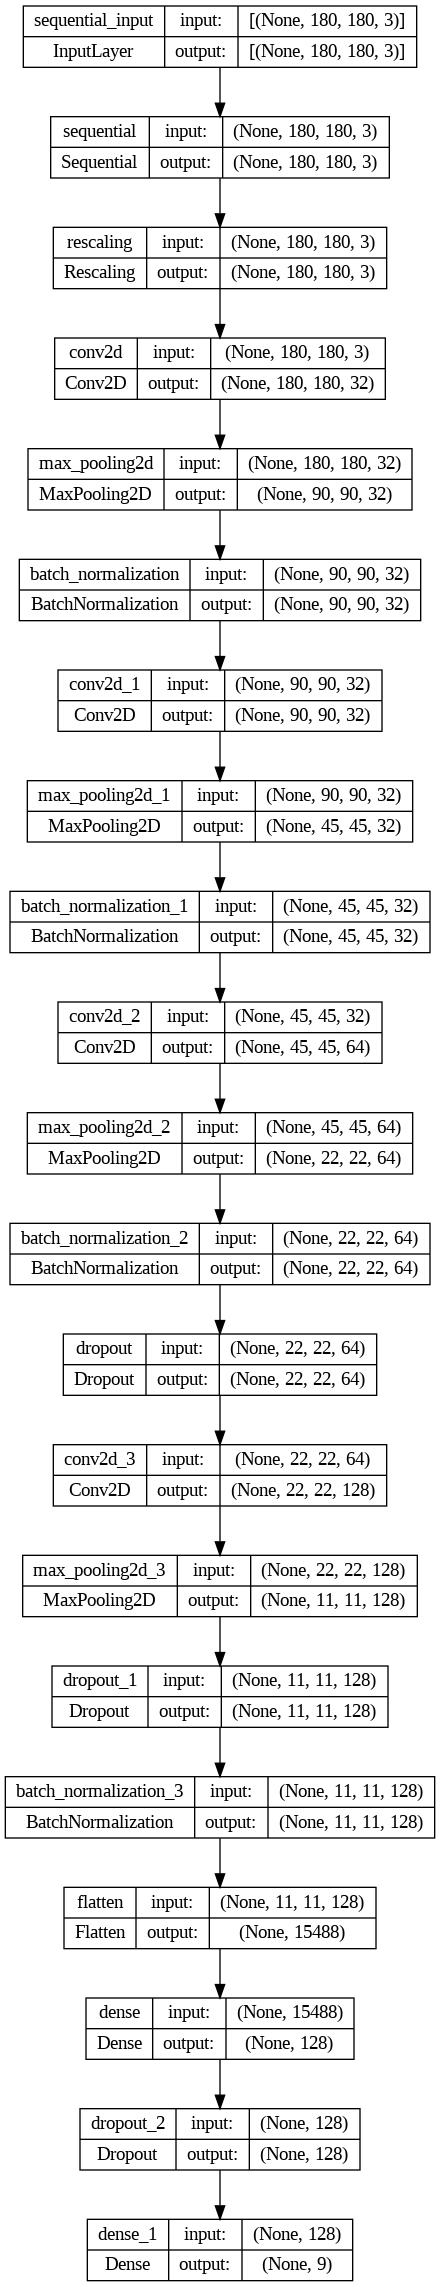

In [72]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### **Todo:**  Train your model

In [73]:
# Train the Model with 50 epochs
epochs = 50
# Setting CheckPoint
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
# Train the Model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - ETA: 0s - loss: 1.9239 - accuracy: 0.3023
Epoch 1: val_accuracy improved from -inf to 0.08612, saving model to model.h5
169/169 [==============================] - 59s 256ms/step - loss: 1.9239 - accuracy: 0.3023 - val_loss: 4.7697 - val_accuracy: 0.0861
Epoch 2/50
168/169 [============================>.] - ETA: 0s - loss: 1.6266 - accuracy: 0.3744
Epoch 2: val_accuracy improved from 0.08612 to 0.18857, saving model to model.h5
169/169 [==============================] - 38s 217ms/step - loss: 1.6278 - accuracy: 0.3743 - val_loss: 3.2246 - val_accuracy: 0.1886
Epoch 3/50
168/169 [============================>.] - ETA: 0s - loss: 1.5413 - accuracy: 0.4036
Epoch 3: val_accuracy improved from 0.18857 to 0.38604, saving model to model.h5
169/169 [==============================] - 38s 221ms/step - loss: 1.5420 - accuracy: 0.4041 - val_loss: 1.6060 - val_accuracy: 0.3860
Epoch 4/50
168/169 [============================>.] - ETA: 0s - loss: 1.5429 - ac

#### **Todo:**  Visualize the model results

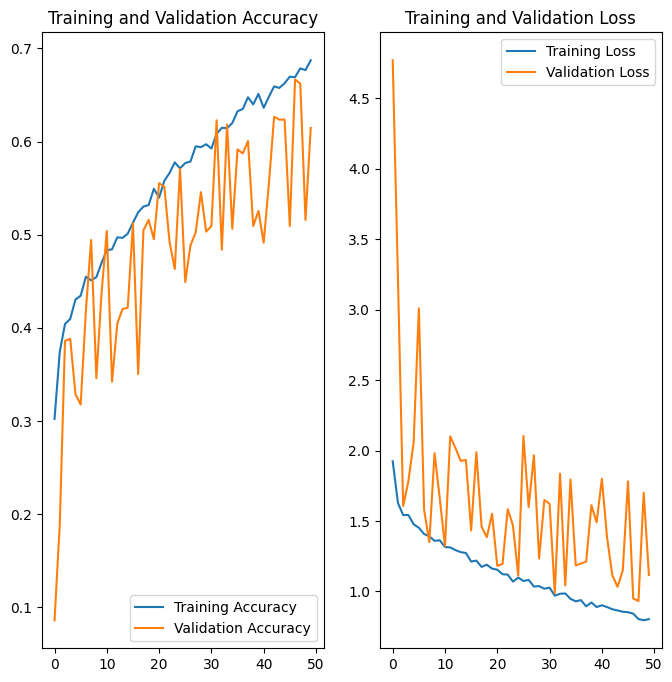

In [74]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range =range(epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [75]:
# Print the Train and Validation Accuracy & Loss
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Train Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Train Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 7s 123ms/step - loss: 1.1169 - accuracy: 0.6147
Train Accuracy:  0.6153560876846313
Validation Accuracy:  0.6146993041038513
Train Loss:  1.009061574935913
Validation Loss 1.1169309616088867


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Observaton:
- Based on the Plot and Above Accuracy & Loss rate, we have addressed the Underfitting and Overfitting problem.
- With Train Accuracy at 61.54 and Validation Accuracy at 61.47, seems we need to improve the accuracy.
- We have tried using DropOut, CallBack, Data Augumentation and Batch Normalization, which are some of the recommended steps to reduce to the OVerfitting / Underfitting.
- However, using the model to predict is debatable as the accuracy is still around 61%.